## Sentiment Analysis
* Testing Glove embeddings vs sum-pooled BERT embeddings for sentiment analysis
* Glove embeddings are fed into bidirectional LSTM
* Can try using `en_vectors_web_lg` and sentencizing on floydhub
* Sum-pooled BERT embeddings are fed into MLP
* Should try other pooling methods for BERT embeddings. Could also try sentencizing a review

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import torch
import cupy
import pickle

from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.utils import to_categorical

import preprocess_utils as prep

%matplotlib inline
%load_ext autoreload
%autoreload 2

is_using_gpu = spacy.prefer_gpu()
if is_using_gpu:
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    
pd.set_option('display.max_columns', 2000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
animes = prep.load_preprocessed_animes()
reviews = prep.load_preprocessed_reviews()

drop_synopsis_vectors = ["synopsis.vector_" + str(i) for i in range(768)]
animes.drop(labels=drop_synopsis_vectors,axis=1, inplace=True)

drop_review_vectors = ["bert_embed." + str(i) for i in range(768)]
reviews.drop(labels=drop_review_vectors, axis=1, inplace=True)

with open("data/reviews_text.pkl", "rb") as f:
    reviews["content"] = pickle.load(f)

In [9]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(reviews, test_size=0.2, random_state=1)
valid_df, test_df = train_test_split(valid_df, test_size=0.2, random_state=1)

In [10]:
print(train_df.shape, valid_df.shape, test_df.shape)

(51031, 13) (10206, 13) (2552, 13)


In [22]:
review_lengths = train_df["content"].str.split().str.len()
print(review_lengths.max(), review_lengths.mean())

11472 533.5196449217143


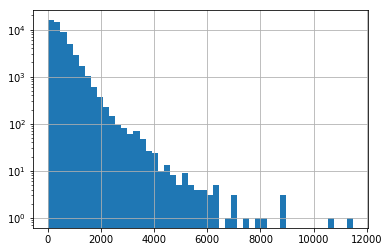

In [12]:
review_lengths.hist(bins=50, log=True)

In [13]:
print(train_df["reviewer.scores.overall"].mean(), train_df["reviewer.scores.overall"].median())

7.392212576669084 8.0


In [14]:
train_df["reviewer.scores.overall"].value_counts()

9     10344
8      9761
10     9065
7      7529
6      4620
5      3270
4      2257
3      2160
2      1092
1       933
Name: reviewer.scores.overall, dtype: int64

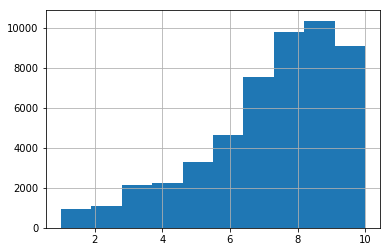

In [15]:
train_df["reviewer.scores.overall"].hist()

In [16]:
def get_embeddings(vocab):
    return cupy.asnumpy(vocab.vectors.data)

def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape["max_length"],
            trainable=False,
            weights=[embeddings],
            mask_zero=True,
        )
    )
    model.add(TimeDistributed(Dense(shape["nr_hidden"], use_bias=False)))
    model.add(
        Bidirectional(
            LSTM(
                shape["nr_hidden"],
                recurrent_dropout=settings["dropout"],
                dropout=settings["dropout"],
            )
        )
    )
    model.add(Dense(shape["nr_class"], activation="sigmoid"))
    model.compile(
        optimizer=Adam(lr=settings["lr"]),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [185]:
def group_sentences(document, num_sentences=4):
    sentence_count = 0
    for token in document:
        if sentence_count % num_sentences == 0 and token.is_sent_start:
            token.is_sent_start = True
            sentence_count += 1
        elif token.is_sent_start:
            token.is_sent_start = False
            sentence_count += 1
    return document

In [17]:
nlp = spacy.load("en_core_web_md", disable=["parser", "tagger", "ner"])
nlp.add_pipe(nlp.create_pipe("sentencizer"))
nlp.add_pipe(group_sentences, last=True)

In [199]:
embeddings = get_embeddings(nlp.vocab)
shape = {"nr_hidden": 128, "max_length": 200, "nr_class": 3}
settings = {"dropout": 0.5, "lr": 0.001}
batch_size = 64
nb_epoch = 5

In [24]:
model = compile_lstm(embeddings, shape, settings)

In [25]:
train_texts = train_df["content"]
valid_texts = valid_df["content"]
test_texts = test_df["content"]

train_labels = pd.cut(train_df["reviewer.scores.overall"], bins=[0,5,7,10],
                       labels=["overall.Negative", "overall.Neutral", "overall.Positive"])
valid_labels = pd.cut(valid_df["reviewer.scores.overall"], bins=[0,5,7,10],
                       labels=["overall.Negative", "overall.Neutral", "overall.Positive"])
test_labels = pd.cut(test_df["reviewer.scores.overall"], bins=[0,5,7,10],
                       labels=["overall.Negative", "overall.Neutral", "overall.Positive"])

In [26]:
def get_features(texts, max_length, nlp, batch_size=64):
    X = np.zeros((len(texts), max_length), dtype="int32")
    i = 0
    sentences = []
    for doc in nlp.pipe(texts, batch_size=batch_size, disable=["parser", "tagger", "ner"]):
        for j, token in enumerate(doc):
            if j >= max_length:
                break
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                X[i, j] = vector_id
            else:
                X[i, j] = 0
        i += 1
    
    return X

def encode_labels(labels, one_hot=True):
    labels = labels.reset_index(drop=True)
    categories = list(labels.unique())
    Y = np.zeros((len(labels), 1))
    
    for i, cat in enumerate(categories):
        Y[labels.index[labels == cat]] = i
    
    if one_hot:
        return to_categorical(Y, num_classes=len(categories))
    else:
        return Y

In [198]:
def get_labelled_sentences_from_doc(doc, doc_label):
    labels = []
    sentences = []
    for sent in doc.sents:
        sentences.append(sent)
        labels.append(y)
    
    return sentences, np.asarray(labels, dtype="int32")

# need to incorporate this when I process the text into docs
def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        for sent in doc.sents:
            sentences.append(sent)
            labels.append(y)
    return sentences, np.asarray(labels, dtype="int32")

In [196]:
for doc in nlp.pipe(train_texts[:2], batch_size=1, disable=["parser", "tagger", "ner"]):
    for i, sent in enumerate(doc.sents):
        print(str(i) + ") "+ sent.text)
    print("--" * 15)

0) like many shows relating to fantasy, magic, and witchcraft, i can’t say that zero kara hajimeru mahou no sho looks any unique compared to the rest at first glance. i mean, if you look at it carefully, the show’s premise is pretty standard that involves a conflict between human and witches. the additional aspect of beastfallen (cursed humans with animalistic appearances) adds some slight intrigue to the story. but is this show really worth investing time in?
1) or is it just a show that panders to fans that wants a dose of fantasy in their life? adapting the light novel of the same name, zero karahajimeru mahou no sho (grimoire of zero) takes a very high fantasy approach with both its characters and story. the most noticeable character is a beastfallen dubbed as “mercenary” by the witch zero. they travel together with albus, another magician and throughout their journey, they learn much more about each other.
2) still, the primary goal of their journey is to find the grimoire of zero

In [189]:
for i, sent in enumerate(doc.sents):
    print(i, sent)

0 this is pure bullshit lol. don't watch this, don't let 7+ rating fool you like it did me, thinking it would be somewhat decent show. go away fast, this isn't the ecchi you're looking for. story is bad, characters are even worse, art is only good for like, 3 seconds per episode and honestly i don't think japanese had seen nipples at this point of history.
1 maybe they discovered it post 2015 or something. i don't know.  sound was bad, enjoyment was less than what i came to this anime fore and overall didn't hold up to expectations of "ecchi harem battle magic and overpowred mc"thing. meh/10 honestly, i just gave 4 or 5 arbitrarily.
2 i came for a 7.25/10 anime, got less than 6/10.


In [46]:
train_X = get_features(train_texts, shape["max_length"], nlp)
valid_X = get_features(valid_texts, shape["max_length"], nlp)

In [47]:
train_Y = encode_labels(train_labels)
valid_Y = encode_labels(valid_labels)

In [139]:
model.fit(train_X[:10,:], train_Y[:10,:], epochs=1, batch_size=2)

Epoch 1/1
10/10 [==============================] - 4s 448ms/step - loss: 1.0475 - acc: 0.4000
